In [1]:
import chipwhisperer as cw
import matplotlib.pyplot as plt
import numpy as np

import simon_64_128
import simon_64_128_simulation

from helper import KeyHypothesis
import helper

from measurement import Measurements, Measurement

/home/nico/miniconda3/envs/simon/lib/python3.13/site-packages/chipwhisperer/capture/trace/TraceWhisperer.py:31: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources # type: ignore


# Import Trace

In [2]:
project = cw.import_project("./traces/07_simon_plain_50000/trace.zip", overwrite=True)

In [3]:
NUM_MEASUREMENTS = len(project.traces)
print(NUM_MEASUREMENTS)

VALS_PER_MEASUREMENT = len(project.traces[0].wave)
print(VALS_PER_MEASUREMENT)

CORR_DIFF_THRESHOLD = 0.05

50000
5000


# Transform Trace Project into Measurement object

In [4]:
plaintexts = np.zeros((NUM_MEASUREMENTS, 2), dtype=np.uint32)
ciphertexts = np.zeros((NUM_MEASUREMENTS, 2), dtype=np.uint32)
powers = np.zeros((NUM_MEASUREMENTS, VALS_PER_MEASUREMENT), dtype=np.uint32)

for i, trace in enumerate(project.traces):
    
    pt = trace.textin
    ct = trace.textout

    plaintexts[i,0] = pt[0] << 24 | pt[1] << 16 | pt[2] << 8 | pt[3]
    plaintexts[i,1] = pt[4] << 24 | pt[5] << 16 | pt[6] << 8 | pt[7]

    ciphertexts[i,0] = ct[0] << 24 | ct[1] << 16 | ct[2] << 8 | ct[3]
    ciphertexts[i,1] = ct[4] << 24 | ct[5] << 16 | ct[6] << 8 | ct[7]
    powers[i,:] = trace.wave

measurements = Measurements(plaintexts, ciphertexts, powers)


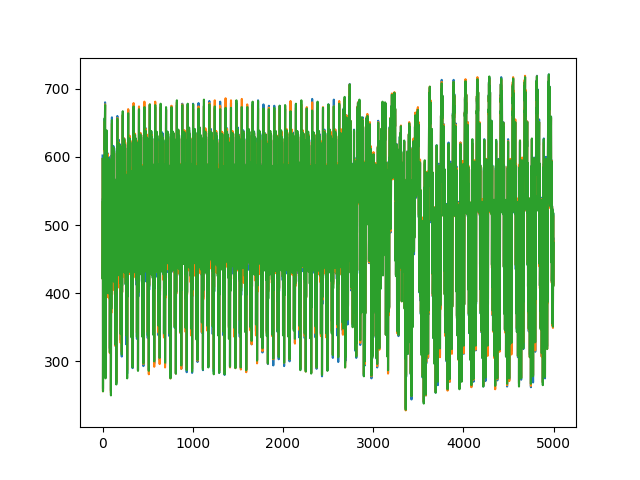

In [5]:
%matplotlib widget

plt.figure()

plt.plot(measurements[0].power)
plt.plot(measurements[1].power)
plt.plot(measurements[2].power)
plt.show()

In [6]:
# key = np.array([0x19013660, 0x86de7696, 0xd0427aff, 0x738dd98a], dtype=np.uint32)
# key = np.array([0x1B1A1918, 0x13121110, 0x0B0A0908, 0x03020100], dtype=np.uint32)
key = np.array([0x8dcc04b1, 0xad004534, 0x8afa7151, 0xf173d6d7], dtype=np.uint32)

pt = measurements[0].plaintext
ct = measurements[0].ciphertext

ct_expect, _ = simon_64_128.encrypt_block(pt, key)

print(ct)
print(ct_expect)

[1904512716 1375627782]
[1904512716 1375627782]


In [7]:
print(measurements.plaintext.shape)
print(measurements.ciphertext.shape)
print(measurements.power.shape)

(50000, 2)
(50000, 2)
(50000, 5000)


# Attack

In [ ]:
# start with empty key as hypothesis
empty_key = np.zeros((4,), dtype=np.uint32)
start_hypo = KeyHypothesis(empty_key, 0)

promising_hypos = [start_hypo]

for attack_step in range(16):
    print(f"Perform Attack Step {attack_step+1}/16")

    sub_hypos: list[KeyHypothesis] = []

    for h in promising_hypos:
        sub_hypos.extend(h.get_sub_hypos())

    print(f"Find correlations for {len(sub_hypos)} hypotheses.")

    helper.calc_corrs_for_hypos(sub_hypos, measurements)
    promising_hypos = helper.filter_hypos(sub_hypos, CORR_DIFF_THRESHOLD)
    
    print(f"Found {len(promising_hypos)} promising hypotheses.")
    for hypo in promising_hypos:
        
        print(f"{helper.array_to_hex_str(hypo.key)}: correlation: {hypo.corr}")

if len(promising_hypos) > 0:
    # Do final check against ciphertext
    for hypo in promising_hypos:
        ciphertext, _ = simon_64_128.encrypt_block(measurements[0].plaintext, hypo.key)
        if np.array_equal(measurements[0].ciphertext, ciphertext):
            extracted_key = hypo.key
            print(f"Extracted Key: {helper.array_to_hex_str(extracted_key)}")
            break
else:
    print("Could not determine key")

Perform Attack Step 1/16
Find correlations for 256 hypotheses.
Found 4 promising hypotheses.
0x00000000 0x00000000 0x00000000 0x00000028: correlation: 0.43889986594001423
0x00000000 0x00000000 0x00000000 0x00000029: correlation: 0.39190906598975644
0x00000000 0x00000000 0x00000000 0x000000D6: correlation: -0.39190906598975644
0x00000000 0x00000000 0x00000000 0x000000D7: correlation: -0.43889986594001423
Perform Attack Step 2/16
Find correlations for 1024 hypotheses.


# Attack Insights

(1, 5000)


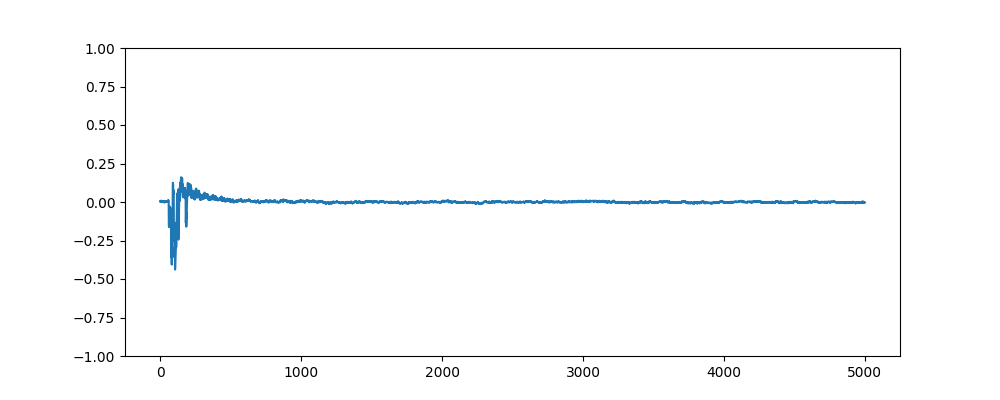

In [19]:
# key = np.array([0x19013660, 0x86de7696, 0xd0427aff, 0x738dd98a], dtype=np.uint32)

key = np.array([0x8dcc04b1, 0xad004534, 0x8afa7151, 0xf173d6d7], dtype=np.uint32)

guessed_keys = np.zeros((1,4), dtype=np.uint32)
guessed_keys[0,3] |= key[3] & 0xFF

expected_hws = simon_64_128_simulation.get_hws_for_guessed_keys(
        measurements.plaintexts, 
        guessed_keys, 
        0, 
        np.uint32(0xFF)
)

corrs = helper.calc_corrs(expected_hws, measurements.power_2d)
print(corrs.shape)

plt.figure(figsize=(10,4))
x = np.arange(len(corrs[0]))
plt.plot(x, corrs[0])
plt.ylim(-1, 1)
plt.show()

In [7]:
measurements100 = Measurements()
measurements100.entries.extend(measurements.entries[0:100])
measurements100.update_arrays()

measurements1000 = Measurements()
measurements1000.entries.extend(measurements.entries[0:1000])
measurements1000.update_arrays()

measurements10000 = Measurements()
measurements10000.entries.extend(measurements.entries[0:10000])
measurements10000.update_arrays()

measurements50000 = Measurements()
measurements50000.entries.extend(measurements.entries[0:50000])
measurements50000.update_arrays()

# start with empty key as hypothesis
empty_key = np.zeros((4,), dtype=np.uint32)
start_hypo = KeyHypothesis(empty_key, 0)
promising_hypos = [start_hypo]

res_all = []

for i, m in enumerate([measurements100, measurements1000, measurements10000, measurements50000]):
    sub_hypos = start_hypo.get_sub_hypos()
    print(f"Find correlations for {len(sub_hypos)} hypotheses.")
    helper.calc_corrs_for_hypos(sub_hypos, m)
    res_all.append([h.corr for h in sub_hypos])

print(res_all)

Find correlations for 256 hypotheses.
Find correlations for 256 hypotheses.
Find correlations for 256 hypotheses.
Find correlations for 256 hypotheses.
[[-0.4851929050661958, -0.4686021863247203, 0.32293364087816634, 0.33930818804900525, -0.4549693359241673, -0.4334180373733775, -0.3061145230403479, -0.3762674030913642, 0.524806218156189, 0.38033256737169346, 0.36486874157959315, -0.4007097780464531, 0.4795713464166149, 0.3482778952004381, -0.3344648346134992, -0.40929642419165146, -0.33270275578783376, 0.33543379589204275, -0.3278995364197935, -0.3530908693385638, -0.33219806827657206, -0.34351865855231384, -0.38673901008806216, -0.338028731499601, 0.4303581267392014, 0.37138804374446654, -0.29437825912543697, 0.33259117112266007, 0.34611916849427926, -0.3536752144457483, 0.3390543516921458, 0.3512945387401863, -0.42026666531448376, -0.4013559931199208, 0.40158185502547616, 0.3950630562752548, -0.4540872938410786, -0.3890987274348024, -0.3721776152626161, -0.3384547168125237, 0.500378

(4, 256)


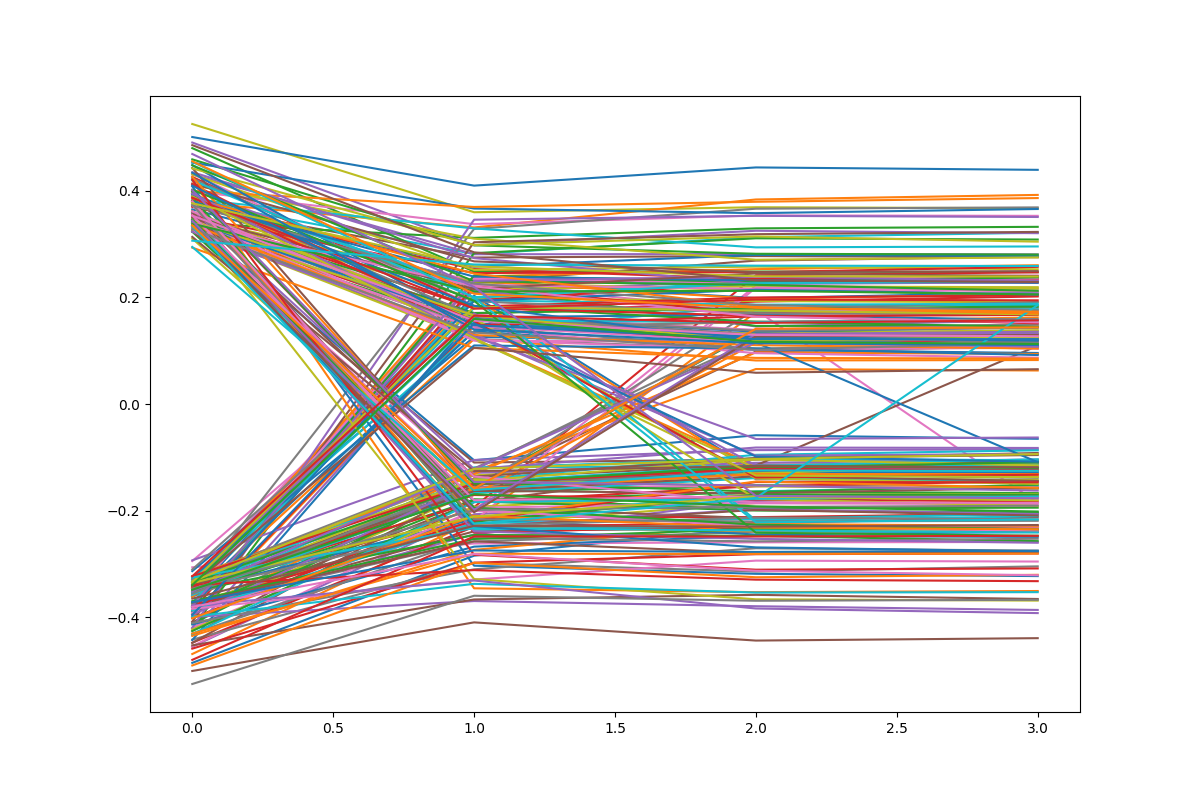

In [12]:
res = np.array(res_all)

print(res.shape)

plt.figure(figsize=(12, 8))

for i in range(res.shape[1]):
    plt.plot(res[:, i])

plt.show()